In [35]:
import pandas as pd
import requests
import time
import numpy as np
import random



In [ ]:
df_matrix = pd.read_csv("google_distance_matrix_coords.csv")


In [23]:
distance_matrix = df_matrix.pivot(index='from_city', columns='to_city', values='distance_miles')
distance_matrix

to_city,"Baltimore, MD","Boise, ID","Boston, MA","Chicago, IL","Cincinnati, OH","Denver, CO","Detroit, MI","Harrisburg, PA","Houston, TX","Las Vegas, NV","Miami, FL","Nashville, TN","New York City, NY","Orlando, FL","Pittsburgh, PA","Portland, ME","Portland, OR","Salt Lake City, UT","Seattle, WA","Washington, DC"
from_city,,,,,,,,,,,,,,,,,,,,
"Baltimore, MD",NaN,2379.12,404.47,701.97,507.89,1664.90,526.07,79.14,1445.51,2410.76,1096.18,702.81,191.51,885.56,247.36,503.07,2805.60,2083.83,2763.69,38.34
"Boise, ID",2381.24,NaN,2661.77,1694.11,1928.57,816.17,1958.96,2336.44,1844.53,623.96,2832.77,1924.96,2468.48,2608.19,2139.43,2760.37,430.08,339.27,504.07,2374.75
"Boston, MA",400.82,2660.63,NaN,983.49,882.54,1971.74,706.74,390.45,1847.88,2715.65,1497.18,1105.18,215.40,1286.56,571.96,112.17,3087.12,2365.34,3045.21,439.34
"Chicago, IL",703.27,1692.55,983.80,NaN,295.44,1003.66,282.23,658.48,1083.36,1747.57,1378.45,470.64,790.51,1153.87,461.46,1082.40,2119.03,1397.26,2063.60,696.79
"Cincinnati, OH",507.35,1945.91,882.58,294.83,NaN,1194.25,262.50,471.33,1049.04,1940.11,1122.87,272.43,639.08,898.28,288.21,981.18,2372.40,1650.62,2327.54,500.87
"Denver, CO",1664.32,816.00,1971.57,1003.91,1192.87,NaN,1268.76,1628.30,1030.76,748.95,2065.47,1157.66,1778.28,1840.88,1449.22,2070.17,1242.49,520.71,1316.47,1657.84
"Detroit, MI",528.70,1960.09,706.69,283.86,264.23,1271.20,NaN,483.91,1311.92,2015.10,1385.75,535.31,615.95,1161.16,286.89,805.29,2386.57,1664.80,2345.58,522.22
"Harrisburg, PA",79.51,2335.11,383.46,657.96,471.20,1628.21,482.06,NaN,1462.25,2374.07,1168.03,719.56,170.44,957.41,203.34,482.06,2761.59,2039.82,2719.68,119.67
"Houston, TX",1446.02,1841.17,1841.36,1082.83,1047.76,1027.13,1299.94,1462.34,NaN,1456.63,1187.17,778.82,1628.34,962.59,1335.64,1939.96,2267.65,1476.62,2341.64,1408.38


In [25]:
destination_cities = df_matrix['to_city'].unique()

In [3]:
#Fetch weather using WeatherAPI
WEATHER_API_KEY = "86c5a381bdf94851a32223705251404"  
weather_cache = {}

for city in destination_cities:
    try:
        url = f"http://api.weatherapi.com/v1/current.json?key={WEATHER_API_KEY}&q={city}"
        response = requests.get(url)
        data = response.json()
        if response.status_code == 200 and "current" in data:
            condition = data["current"]["condition"]["text"]
        else:
            condition = "unknown"
    except Exception as e:
        condition = "unknown"
    weather_cache[city] = condition
    time.sleep(1)  


In [5]:
#Add weather info to matrix
df_matrix["weather"] = df_matrix["to_city"].map(weather_cache)
df_matrix

,from_city,to_city,distance_miles,duration_minutes,weather
0,"Harrisburg, PA","Nashville, TN",719.56,640.18,Partly cloudy
1,"Harrisburg, PA","Salt Lake City, UT",2039.82,1796.37,Partly cloudy
2,"Harrisburg, PA","Denver, CO",1628.21,1438.48,Patchy light rain with thunder
3,"Harrisburg, PA","New York City, NY",170.44,170.40,Sunny
4,"Harrisburg, PA","Cincinnati, OH",471.20,437.00,Sunny
...,...,...,...,...,...
375,"Portland, OR","Las Vegas, NV",969.87,923.97,Sunny
376,"Portland, OR","Chicago, IL",2120.40,1844.62,Sunny
377,"Portland, OR","Boston, MA",3088.06,2706.17,Clear
378,"Portland, OR","Boise, ID",429.95,395.65,Overcast


In [7]:
#Adjust duration based on weather impact
def adjust_duration(row):
    duration = row["duration_minutes"]
    condition = str(row["weather"]).lower()
    if pd.isna(duration):
        return None
    if any(term in condition for term in ["snow", "blizzard", "flurries"]):
        return duration * 1.20
    elif any(term in condition for term in ["rain", "shower", "drizzle", "storm"]):
        return duration * 1.10
    else:
        return duration

df_matrix["adjusted_duration_minutes"] = df_matrix.apply(adjust_duration, axis=1)


In [13]:
# Save updated version
df_matrix.to_csv("google_distance_matrix_adjusted.csv", index=False)

"google_distance_matrix_adjusted.csv with adjusted durations saved"


'google_distance_matrix_adjusted.csv with adjusted durations saved'

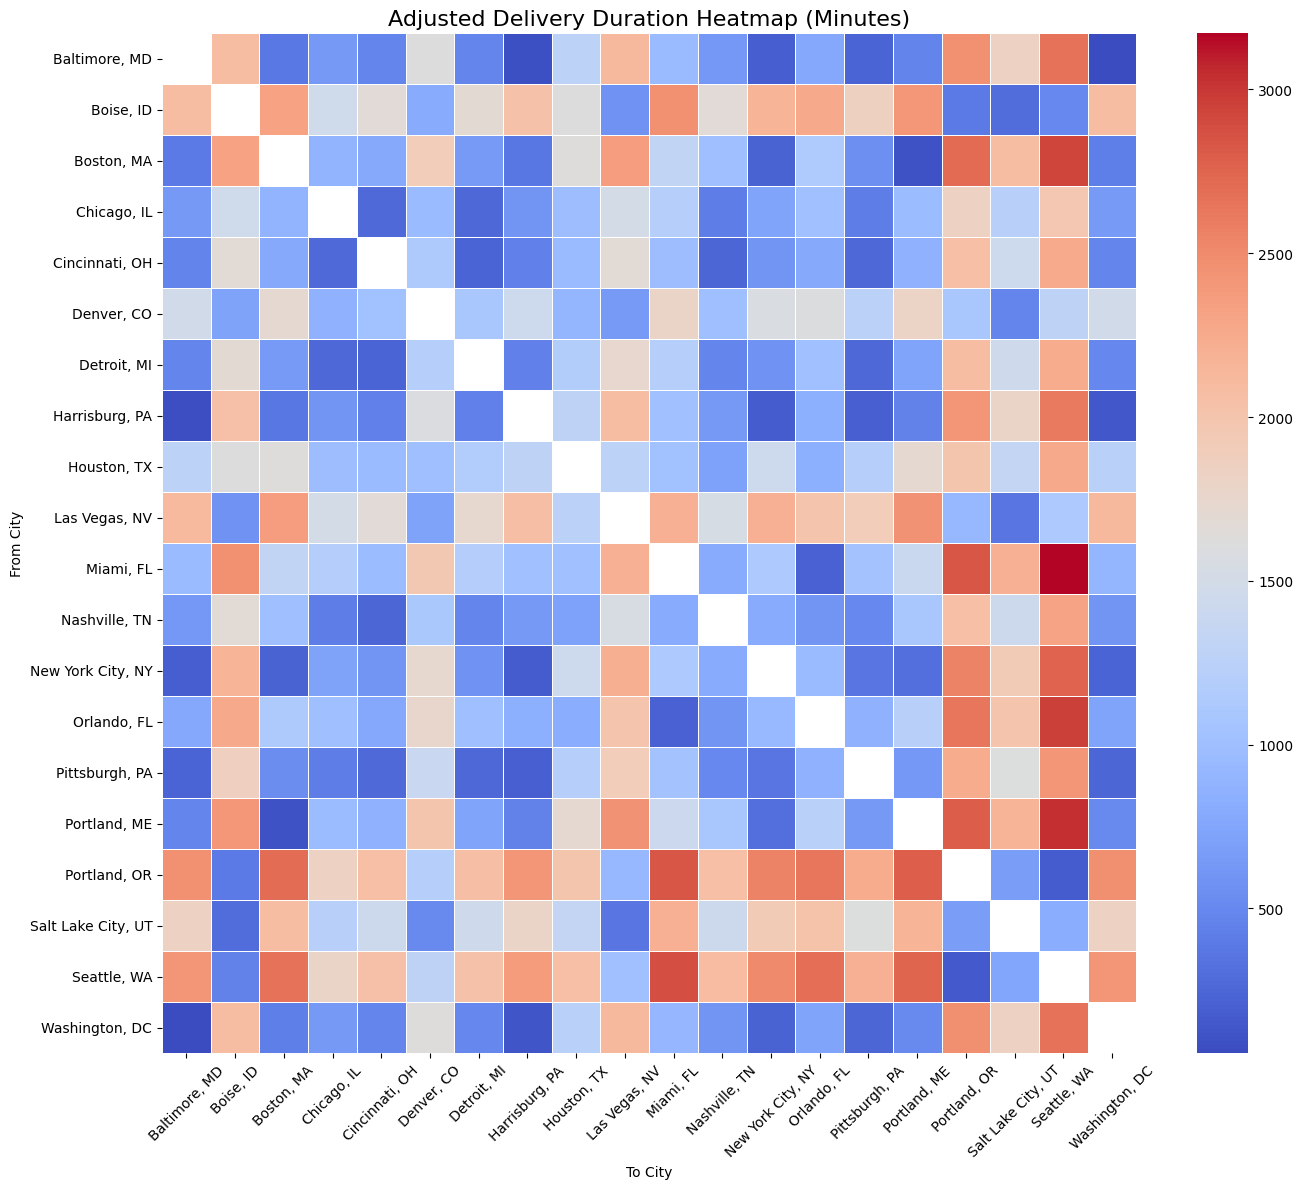

'Heatmap created and saved as adjusted_delay_heatmap.png'

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_matrix = pd.read_csv("google_distance_matrix_adjusted.csv")

#Create pivot table for heatmap of adjusted delays
delay_matrix = df_matrix.pivot(index='from_city', columns='to_city', values='adjusted_duration_minutes')

plt.figure(figsize=(14, 12))
sns.heatmap(delay_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Adjusted Delivery Duration Heatmap (Minutes)", fontsize=16)
plt.xlabel("To City")
plt.ylabel("From City")
plt.xticks(rotation=45)
plt.tight_layout()

# Save the heatmap image
plt.savefig("adjusted_delay_heatmap.png")
plt.show()

"Heatmap created and saved as adjusted_delay_heatmap.png"


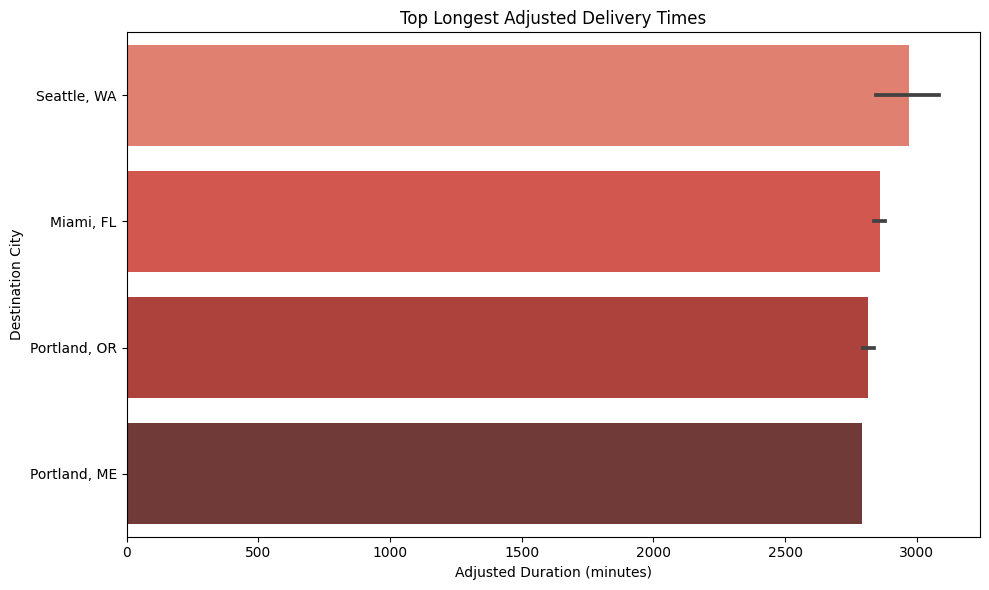

In [87]:

#Top longest adjusted delivery durations
top_delays = df_matrix.sort_values("adjusted_duration_minutes", ascending=False).head(10)

#Weather condition distribution
weather_counts = df_matrix["weather"].value_counts().head(10)

#Average adjusted delivery time per weather type
avg_delay_by_weather = df_matrix.groupby("weather")["adjusted_duration_minutes"].mean().sort_values(ascending=False).head(10)

# Top 10 longest adjusted delivery durations
plt.figure(figsize=(10, 6))
sns.barplot(data=top_delays, x="adjusted_duration_minutes", y="to_city", palette="Reds_d")
plt.title("Top Longest Adjusted Delivery Times")
plt.xlabel("Adjusted Duration (minutes)")
plt.ylabel("Destination City")
plt.tight_layout()
plt.savefig("top_10_delays.png")
plt.show()

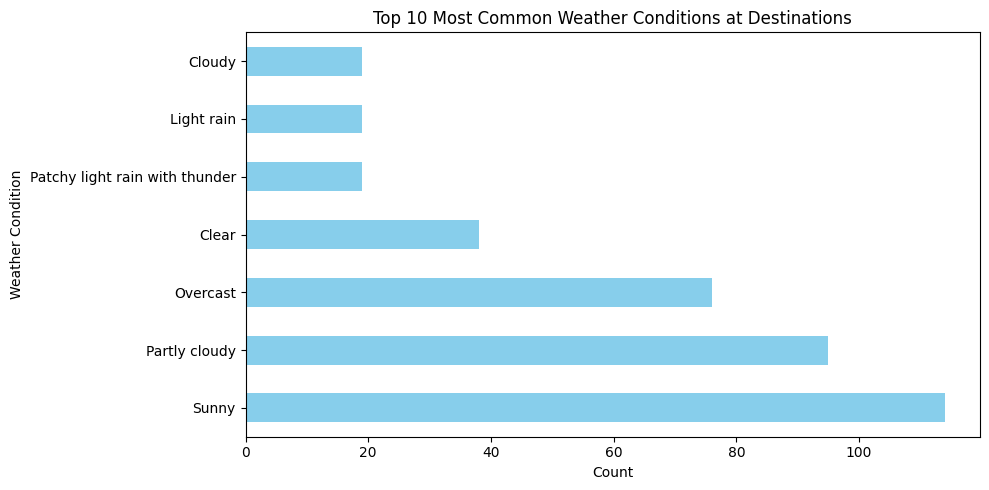

In [63]:
# Weather distribution
plt.figure(figsize=(10, 5))
weather_counts.plot(kind="barh", color="skyblue")
plt.title("Top 10 Most Common Weather Conditions at Destinations")
plt.xlabel("Count")
plt.ylabel("Weather Condition")
plt.tight_layout()
plt.savefig("weather_distribution.png")
plt.show()

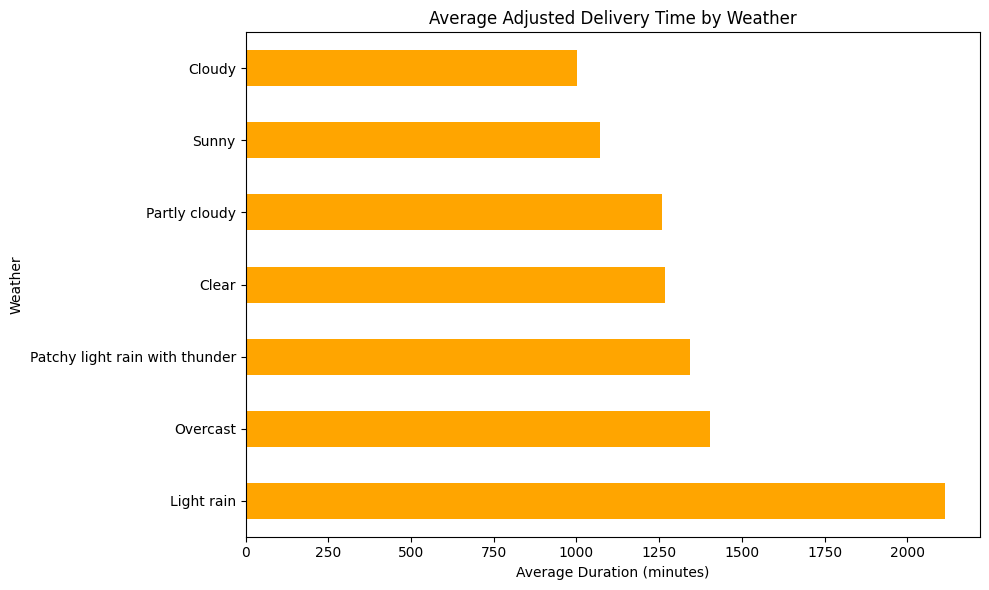

In [65]:
# Average delay per weather condition
plt.figure(figsize=(10, 6))
avg_delay_by_weather.plot(kind="barh", color="orange")
plt.title("Average Adjusted Delivery Time by Weather")
plt.xlabel("Average Duration (minutes)")
plt.ylabel("Weather")
plt.tight_layout()
plt.savefig("avg_delay_by_weather.png")
plt.show()


In [29]:
# Build distance lookup
cities = sorted(set(df_matrix['from_city'].unique()) | set(df_matrix['to_city'].unique()))
distance_lookup = {city: {} for city in cities}
for _, row in df_matrix.iterrows():
    if pd.notnull(row['adjusted_duration_minutes']):
        distance_lookup[row['from_city']][row['to_city']] = row['adjusted_duration_minutes']


In [31]:

def route_distance(route):
    dist = 0
    for i in range(len(route) - 1):
        dist += distance_lookup[route[i]].get(route[i+1], 0)
    dist += distance_lookup[route[-1]].get(route[0], 0)
    return dist

def create_route(city_list):
    route = city_list[:]
    random.shuffle(route)
    return route

def initial_population(pop_size, city_list):
    return [create_route(city_list) for _ in range(pop_size)]

def rank_routes(population):
    return sorted([(route, route_distance(route)) for route in population], key=lambda x: x[1])

def selection(ranked, elite_size):
    selected = [route for route, _ in ranked[:elite_size]]
    rest = random.choices([route for route, _ in ranked], k=len(ranked) - elite_size)
    return selected + rest

def crossover(parent1, parent2):
    start, end = sorted(random.sample(range(len(parent1)), 2))
    child_p1 = parent1[start:end]
    child = child_p1 + [city for city in parent2 if city not in child_p1]
    return child

def mutate(route, mutation_rate=0.01):
    for swapped in range(len(route)):
        if random.random() < mutation_rate:
            swap_with = int(random.random() * len(route))
            route[swapped], route[swap_with] = route[swap_with], route[swapped]
    return route

def evolve(population, elite_size, mutation_rate):
    ranked = rank_routes(population)
    selected = selection(ranked, elite_size)
    children = []

    for i in range(elite_size):
        children.append(selected[i])
    for i in range(len(population) - elite_size):
        parent1 = random.choice(selected)
        parent2 = random.choice(selected)
        child = crossover(parent1, parent2)
        children.append(mutate(child, mutation_rate))

    return children, ranked[0]



In [45]:

# === Step 4: Run GA ===
city_list = [c for c in cities if c != "Harrisburg, PA"]
generations = 200
population = initial_population(100, city_list)
best_route = None

for i in range(generations):
    population, best = evolve(population, elite_size=20, mutation_rate=0.02)
    if i % 10 == 0:
        print(f"Gen {i} Best Distance: {round(best[1], 2)}")
    best_route = best

# Final route
ga_route = ["Harrisburg, PA"] + best_route[0] + ["Harrisburg, PA"]
ga_total_distance = round(route_distance(ga_route), 2)

ga_route, ga_total_distance

Gen 0 Best Distance: 16663.06
Gen 10 Best Distance: 14227.01
Gen 20 Best Distance: 11512.13
Gen 30 Best Distance: 10521.37
Gen 40 Best Distance: 10521.37
Gen 50 Best Distance: 9986.81
Gen 60 Best Distance: 9698.75
Gen 70 Best Distance: 9669.43
Gen 80 Best Distance: 9669.43
Gen 90 Best Distance: 9237.0
Gen 100 Best Distance: 9021.81
Gen 110 Best Distance: 8968.23
Gen 120 Best Distance: 8961.37
Gen 130 Best Distance: 8961.37
Gen 140 Best Distance: 8961.11
Gen 150 Best Distance: 8961.11
Gen 160 Best Distance: 8961.11
Gen 170 Best Distance: 8961.11
Gen 180 Best Distance: 8961.11
Gen 190 Best Distance: 8961.11


(['Harrisburg, PA',
  'Cincinnati, OH',
  'Detroit, MI',
  'Chicago, IL',
  'Denver, CO',
  'Salt Lake City, UT',
  'Boise, ID',
  'Portland, OR',
  'Seattle, WA',
  'Las Vegas, NV',
  'Houston, TX',
  'Nashville, TN',
  'Orlando, FL',
  'Miami, FL',
  'Washington, DC',
  'Baltimore, MD',
  'New York City, NY',
  'Boston, MA',
  'Portland, ME',
  'Pittsburgh, PA',
  'Harrisburg, PA'],
 9327.26)

In [75]:
print("\n Best Weather-Aware GA Route:\n")
print(" -> ".join(ga_route))
print(f"\n Total Distance adjusted with weather: {ga_total_distance} miles")


 Best Weather-Aware GA Route:

Harrisburg, PA -> Cincinnati, OH -> Detroit, MI -> Chicago, IL -> Denver, CO -> Salt Lake City, UT -> Boise, ID -> Portland, OR -> Seattle, WA -> Las Vegas, NV -> Houston, TX -> Nashville, TN -> Orlando, FL -> Miami, FL -> Washington, DC -> Baltimore, MD -> New York City, NY -> Boston, MA -> Portland, ME -> Pittsburgh, PA -> Harrisburg, PA

 Total Distance adjusted with weather: 9327.26 miles


In [53]:
city_coords = {
    "Harrisburg, PA": [40.2732, -76.8844],
    "Nashville, TN": [36.1627, -86.7816],
    "Salt Lake City, UT": [40.7608, -111.8910],
    "Denver, CO": [39.7392, -104.9903],
    "New York City, NY": [40.7128, -74.0060],
    "Cincinnati, OH": [39.1031, -84.5120],
    "Seattle, WA": [47.6062, -122.3321],
    "Orlando, FL": [28.5383, -81.3792],
    "Washington, DC": [38.9072, -77.0369],
    "Detroit, MI": [42.3314, -83.0458],
    "Houston, TX": [29.7604, -95.3698],
    "Miami, FL": [25.7617, -80.1918],
    "Baltimore, MD": [39.2904, -76.6122],
    "Pittsburgh, PA": [40.4406, -79.9959],
    "Las Vegas, NV": [36.1699, -115.1398],
    "Chicago, IL": [41.8781, -87.6298],
    "Boston, MA": [42.3601, -71.0589],
    "Boise, ID": [43.6150, -116.2023],
    "Portland, ME": [43.6591, -70.2553],
    "Portland, OR": [45.5051, -122.6765],
}


In [85]:
import folium

# Create map centered at Harrisburg
m = folium.Map(location=city_coords["Harrisburg, PA"], zoom_start=5)

# Plot cities and draw the route
for i, city in enumerate(ga_route):
    coord = city_coords.get(city)
    if coord:
        folium.Marker(location=coord, popup=city).add_to(m)
        if i < len(ga_route) - 1:
            next_city = ga_route[i + 1]
            next_coord = city_coords.get(next_city)
            if next_coord:
                folium.PolyLine([coord, next_coord], color="blue", weight=2.5).add_to(m)


display(m)



## Route Optimization Comparison: TSP vs Genetic Algorithm

| Method                     | Total Distance (miles) | Weather Adjusted Distance (miles) |
|----------------------------|------------------------|------------------------------------|
| TSP (Greedy Heuristic)  | 10,047.69              | Not Adjusted                   |
| Genetic Algorithm (GA)  | 9,758.64               | 9,327.26       

Conclusion

- The **Genetic Algorithm** provided a more efficient delivery route than the traditional **TSP heuristic**, saving nearly **289 miles** in raw distance.
- After accounting for **weather delays**, the Genetic Algorithm route was further optimized to **9327.26 miles** — a **7.2% improvement** over TSP.
- This shows that real-world conditions like **rain, snow, and traffic** significantly impact logistics and should be considered in any practical shipping solution.
- Genetic Algorithm is more flexible and scalable for large datasets and dynamic environments.
